In [1]:
import networkx as nx
import matplotlib.pyplot as plt

from factorio_design_compiler.fdc_utils import bp_string_to_json
from factorio_design_compiler.belts_node import BeltNode, L1Belt
import numpy as np
import pandas as pd

%load_ext autoreload
%autoreload 2

# Second try BeltsGraph

In [2]:
basic_belts = bp_string_to_json('0eJydldFugyAUht/lXNMGUGvxcq+xNI22ZCFRNEiXGeO7D+fWLDmSerxTge+cfPLDCFX90J0z1kMxgrm1tofifYTefNiynr/5odNQgPG6AQa2bOY370rbd63zh0rXHiYGxt71FxRiujDQ1htv9EJaX8Gga/swqbVzjbDwkBwzBkN4kMcs8O7G6dsyLn+Jw9U+mkq7uQrbDhZRcIrAkgDmUe4JcRMCV0a5HHFTioinYf7acEYByygYGz5RwJzQcb7n1yEuVnzeo1i87lftMYy4WLDge8KBwHgPC0rq+HYRghK6aL8rIiih++t3y+FDCZ0gcCmZi0duBUzJXPyQWNkRlMwlMRM4coKSuWjkVnaEmm+nn5us+HfxMfjUrl/knUWaK5mnUqlECQZ1GaqG2W/P2dP0DWvKW7E=')

In [3]:
# Get the actual design layout
basic_belts_entities = basic_belts.get('blueprint').get('entities')
basic_belts_entities

[{'name': 'transport-belt',
  'position': {'x': -3.5, 'y': -2.5},
  'direction': 2,
  'entity_number': 1},
 {'name': 'transport-belt',
  'position': {'x': -1.5, 'y': -2.5},
  'direction': 4,
  'entity_number': 2},
 {'name': 'transport-belt',
  'position': {'x': 0.5, 'y': -2.5},
  'direction': 6,
  'entity_number': 3},
 {'name': 'transport-belt',
  'position': {'x': 2.5, 'y': -2.5},
  'direction': 0,
  'entity_number': 4},
 {'name': 'transport-belt',
  'position': {'x': -3.5, 'y': -0.5},
  'direction': 2,
  'entity_number': 5},
 {'name': 'transport-belt',
  'position': {'x': -2.5, 'y': -0.5},
  'direction': 4,
  'entity_number': 6},
 {'name': 'transport-belt',
  'position': {'x': -0.5, 'y': -0.5},
  'direction': 2,
  'entity_number': 7},
 {'name': 'transport-belt',
  'position': {'x': 0.5, 'y': -0.5},
  'direction': 0,
  'entity_number': 8},
 {'name': 'transport-belt',
  'position': {'x': -3.5, 'y': 1.5},
  'direction': 2,
  'entity_number': 9},
 {'name': 'transport-belt',
  'position':

In [250]:
basic_belts_df = pd.DataFrame.from_dict(basic_belts_entities)
basic_belts_df = basic_belts_df[basic_belts_df.name == 'transport-belt']
basic_belts_df.drop('entity_number', axis=1, inplace=True, errors='ignore')

def get_position_int_x(d: dict) -> int:
    x_raw_float = d.get('x')
    x_int = int(x_raw_float * 2)
    return x_int

def get_position_int_y(d: dict) -> int:
    y_raw_float = d.get('y')
    y_int = int(y_raw_float * 2)
    return y_int

basic_belts_df['x'] = basic_belts_df.position.map(get_position_int_x)
basic_belts_df['y'] = basic_belts_df.position.map(get_position_int_y)
basic_belts_df.drop('position', axis=1, inplace=True, errors='ignore')
basic_belts_df['direction_we'] = ((basic_belts_df.direction // 2) % 2).astype(int)
basic_belts_df['direction_ns'] = ((basic_belts_df.direction // 2 + 1) % 2).astype(int)
basic_belts_df['direction_ne'] = ((basic_belts_df.direction // 2) < 2).astype(int)
basic_belts_df['x_snap'] = basic_belts_df.x // 2 * 2
basic_belts_df['y_snap'] = basic_belts_df.y // 2 * 2
basic_belts_df['x_with_side'] = list(zip(
    basic_belts_df.x - basic_belts_df.direction_ns,
    basic_belts_df.x
))
basic_belts_df['x_spouse'] = list(zip(
    basic_belts_df.x,
    basic_belts_df.x - basic_belts_df.direction_ns
))
basic_belts_df['y_with_side'] = list(zip(
    basic_belts_df.y - basic_belts_df.direction_we,
    basic_belts_df.y
))
basic_belts_df['y_spouse'] = list(zip(
    basic_belts_df.y,
    basic_belts_df.y - basic_belts_df.direction_we
))
basic_belts_df = basic_belts_df.explode(column=['x_with_side', 'y_with_side', 'x_spouse', 'y_spouse'])
basic_belts_df['x_with_side'] -= basic_belts_df.direction_we * (1 - basic_belts_df.direction_ne)
basic_belts_df['y_with_side'] -= basic_belts_df.direction_ns * (basic_belts_df.direction_ne)
basic_belts_df['x_spouse'] -= basic_belts_df.direction_we * (1 - basic_belts_df.direction_ne)
basic_belts_df['y_spouse'] -= basic_belts_df.direction_ns * (basic_belts_df.direction_ne)
basic_belts_df.name = basic_belts_df.name + '-side'
basic_belts_df['x_delta'] = basic_belts_df.direction_we * 2 * (basic_belts_df.direction_ne * 2 - 1)
basic_belts_df['y_delta'] = basic_belts_df.direction_ns * 2 * (1 - basic_belts_df.direction_ne * 2)
basic_belts_df['direction'] //= 2
basic_belts_df

,name,direction,x,y,direction_we,direction_ns,direction_ne,x_snap,y_snap,x_with_side,x_spouse,y_with_side,y_spouse,x_delta,y_delta
0,transport-belt-side,1,-7,-5,1,0,1,-8,-6,-7,-7,-6,-5,2,0
0,transport-belt-side,1,-7,-5,1,0,1,-8,-6,-7,-7,-5,-6,2,0
1,transport-belt-side,2,-3,-5,0,1,0,-4,-6,-4,-3,-5,-5,0,2
1,transport-belt-side,2,-3,-5,0,1,0,-4,-6,-3,-4,-5,-5,0,2
2,transport-belt-side,3,1,-5,1,0,0,0,-6,0,0,-6,-5,-2,0
2,transport-belt-side,3,1,-5,1,0,0,0,-6,0,0,-5,-6,-2,0
3,transport-belt-side,0,5,-5,0,1,1,4,-6,4,5,-6,-6,0,-2
3,transport-belt-side,0,5,-5,0,1,1,4,-6,5,4,-6,-6,0,-2
4,transport-belt-side,1,-7,-1,1,0,1,-8,-2,-7,-7,-2,-1,2,0
4,transport-belt-side,1,-7,-1,1,0,1,-8,-2,-7,-7,-1,-2,2,0


n: (-7, -6)
{'entity_pos': (-7, -5), 'pos': (-7, 6), 'delta': (2, 0), 'spouse': (-7, -5), 'direction': 1}
{'entity_pos': (-7, -5), 'pos': (-7, 5), 'delta': (2, 0), 'spouse': (-7, -6), 'direction': 1}

n: (-4, -5)
{'entity_pos': (-3, -5), 'pos': (-4, 5), 'delta': (0, 2), 'spouse': (-3, -5), 'direction': 2}
{'entity_pos': (-3, -5), 'pos': (-3, 5), 'delta': (0, 2), 'spouse': (-4, -5), 'direction': 2}

n: (0, -5)
{'entity_pos': (1, -5), 'pos': (0, 5), 'delta': (-2, 0), 'spouse': (0, -6), 'direction': 3}
{'entity_pos': (1, -5), 'pos': (0, 6), 'delta': (-2, 0), 'spouse': (0, -5), 'direction': 3}

n: (5, -6)
{'entity_pos': (5, -5), 'pos': (5, 6), 'delta': (0, -2), 'spouse': (4, -6), 'direction': 0}
{'entity_pos': (5, -5), 'pos': (4, 6), 'delta': (0, -2), 'spouse': (5, -6), 'direction': 0}

n: (-7, -2)
{'entity_pos': (-7, -1), 'pos': (-7, 2), 'delta': (2, 0), 'spouse': (-7, -1), 'direction': 1}
{'entity_pos': (-7, -1), 'pos': (-7, 1), 'delta': (2, 0), 'spouse': (-7, -2), 'direction': 1}

n: (-

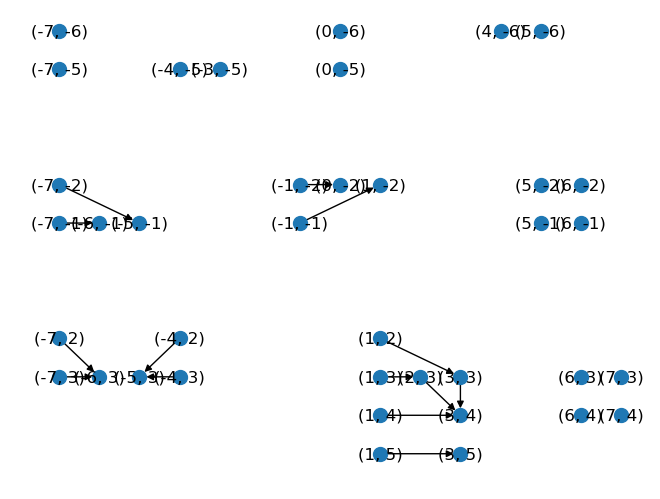

In [316]:
belts_graph = nx.DiGraph()
for i, row in basic_belts_df.iterrows():
    belts_graph.add_node(
        (row.x_with_side, row.y_with_side),
        entity_pos=(row.x, row.y),
        pos=(row.x_with_side, -row.y_with_side),
        delta=(row.x_delta, row.y_delta),
        spouse=(row.x_spouse, row.y_spouse),
        direction=row.direction
    )
for n in list(belts_graph.nodes):
    if (n[0] + n[1]) % 2:
        node = belts_graph.nodes.get(n)
        print(f'n: {n}')
        print(node)
        n_spouse = node['spouse']
        node_spouse = belts_graph.nodes.get(n_spouse)
        print(node_spouse)
        behind = (n[0] - node['delta'][0], n[1] - node['delta'][1])
        behind_spouse = (n_spouse[0] - node['delta'][0], n_spouse[1] - node['delta'][1])
        behind_node = belts_graph.nodes.get(behind)
        if behind_node:
            print('Watch behind!')
            belts_graph.add_edge(behind, n)
            belts_graph.add_edge(behind_spouse, n_spouse)
        if node['direction'] == 1:
            left_n = (n[0], min(n[1], n_spouse[1]))
            right_n = (n[0], max(n[1], n_spouse[1]))
            lf_n = (left_n[0], left_n[1] - 1)
            lr_n = (left_n[0] - 1, left_n[1] - 1)
            rf_n = (right_n[0], right_n[1] + 1)
            rr_n = (right_n[0] - 1, right_n[1] + 1)
        elif node['direction'] == 2:
            left_n = (max(n[0], n_spouse[0]), n[1])
            right_n = (min(n[0], n_spouse[0]), n[1])
            lf_n = (left_n[0] + 1, left_n[1])
            lr_n = (left_n[0] + 1, left_n[1] - 1)
            rf_n = (right_n[0] - 1, right_n[1])
            rr_n = (right_n[0] - 1, right_n[1] - 1)
        elif node['direction'] == 3:
            left_n = (n[0], max(n[1], n_spouse[1]))
            right_n = (n[0], min(n[1], n_spouse[1]))
            lf_n = (left_n[0], left_n[1] + 1)
            lr_n = (left_n[0] + 1, left_n[1] + 1)
            rf_n = (right_n[0], right_n[1] - 1)
            rr_n = (right_n[0] - 1, right_n[1] - 1)
        else:
            left_n = (min(n[0], n_spouse[0]), n[1])
            right_n = (max(n[0], n_spouse[0]), n[1])
            lf_n = (left_n[0] - 1, left_n[1])
            lr_n = (left_n[0] - 1, left_n[1] + 1)
            rf_n = (right_n[0] + 1, right_n[1])
            rr_n = (right_n[0] + 1, right_n[1] + 1)
        assert (left_n == n) or (right_n == n)
        assert (left_n == n_spouse) or (right_n == n_spouse)
        watch_left, watch_right = False, False
        if lf_n in belts_graph and lr_n in belts_graph:
            watch_left = True
            print('Watch left!')
        if rf_n in belts_graph and rr_n in belts_graph:
            watch_right = True
            print('Watch right!')
        if behind_node or (watch_left and watch_right):
            if watch_left:
                belts_graph.add_edge(lf_n, left_n)
                belts_graph.add_edge(lr_n, left_n)
            if watch_right:
                belts_graph.add_edge(rf_n, right_n)
                belts_graph.add_edge(rr_n, right_n)
        elif watch_left:
            belts_graph.add_edge(lf_n, left_n)
            belts_graph.add_edge(lr_n, right_n)
        elif watch_right:
            belts_graph.add_edge(rf_n, right_n)
            belts_graph.add_edge(rr_n, left_n)
        print()
            

pos = nx.get_node_attributes(belts_graph, 'pos')
# img = plt.imread('basic_belts_background.png')
nx.draw(belts_graph, pos=pos, node_size=100, with_labels=True)
# plt.imshow(img, extent=[-10, 9.5, -6.5, 6.5])
plt.draw()

In [190]:
x_pos = (3, 5)
x = belts_graph.nodes.get(x_pos)
behind = (x_pos[0] - x['delta'][0], x_pos[1] - x['delta'][1])
behind_node = belts_graph.nodes.get(behind)
behind_node

{'entity_pos': (1, 5), 'pos': (1, -5), 'delta': (2, 0), 'spouse': (1, 4)}

n: (-5, -8)
{'entity_pos': (-5, -7), 'pos': (-5, 8), 'delta': (2, 0), 'spouse': (-5, -7), 'direction': 1}
{'entity_pos': (-5, -7), 'pos': (-5, 7), 'delta': (2, 0), 'spouse': (-5, -8), 'direction': 1}
Watch behind!

n: (-4, -7)
{'entity_pos': (-3, -7), 'pos': (-4, 7), 'delta': (0, 2), 'spouse': (-3, -7), 'direction': 2}
{'entity_pos': (-3, -7), 'pos': (-3, 7), 'delta': (0, 2), 'spouse': (-4, -7), 'direction': 2}
Watch right!

n: (-7, -8)
{'entity_pos': (-7, -7), 'pos': (-7, 8), 'delta': (2, 0), 'spouse': (-7, -7), 'direction': 1}
{'entity_pos': (-7, -7), 'pos': (-7, 7), 'delta': (2, 0), 'spouse': (-7, -8), 'direction': 1}

n: (-7, -6)
{'entity_pos': (-7, -5), 'pos': (-7, 6), 'delta': (2, 0), 'spouse': (-7, -5), 'direction': 1}
{'entity_pos': (-7, -5), 'pos': (-7, 5), 'delta': (2, 0), 'spouse': (-7, -6), 'direction': 1}

n: (-6, -5)
{'entity_pos': (-5, -5), 'pos': (-6, 5), 'delta': (0, 2), 'spouse': (-5, -5), 'direction': 2}
{'entity_pos': (-5, -5), 'pos': (-5, 5), 'delta': (0, 2), 'spou

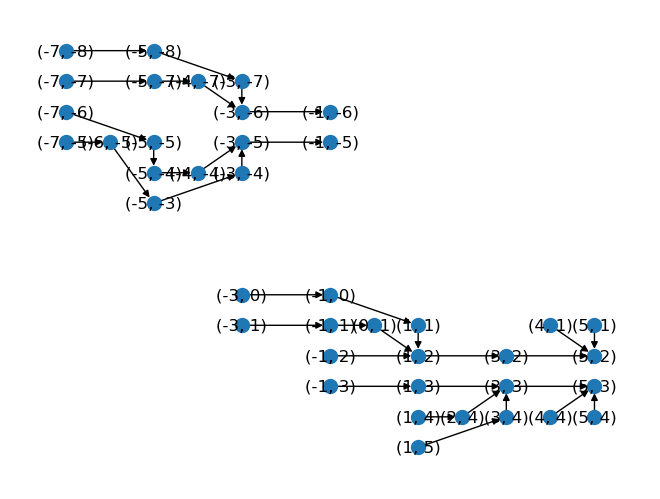

In [3]:
from factorio_design_compiler.belts_graph import BeltsGraph

bp_s = '0eJydldtugzAMQP/Fz2mFDYzC435jqipooykSBBTSaQjx7wtjnSZlqHHeuDjHxvjIMzTtXQ5GaQvVDOra6xGqtxlG9a7rdn1mp0FCBcrKDgToulvvrKn1OPTGHhrZWlgEKH2Tn1DhchYgtVVWyY30/wkBQz+6oF6vOdzBAx1zAZO7SI+5492UkdftPf0Qp4u+d400axYRDsZdcOaBiQNOGRWnUWB6Ds44YNoF+63Io8D4vOKXqJ/ngRMPXESBA3p84oATBriMqTgJ8COJqTgEzDFvl+sPG7LEe4ADhg054nG4HO+QweVo96g3YNKQYx3ucX3nkCMdMfrAcY4Yg8ZRjsL7QMm6+L6XZPVnpwr4kGbcvvGEWVFSkVFZpiUKaGuX1UW//kYvyxed5Xj5'
bg = BeltsGraph(bp_s)
graph = bg.graph
pos = nx.get_node_attributes(graph, 'pos')
nx.draw(graph, pos=pos, node_size=100, with_labels=True)

# Underground belts

In [2]:
underground_belts = bp_string_to_json('0eJyVkMEKwjAQRP9lzqvYWNHm6G+ISGsXCbSbkiZiKf13EwvFg4Kekmxm5u3uiKoJ3DkjHnqEuVrpoU8jenOTskk1P3QMDeO5BUHKNr2C1OxuzsZzVXHjMRFMrD2gs+lMYPHGG56zvnkIne2jzEriROtKrXeEIV42611MrI3j6/yvaGlEupC8L8RwkdBW7BKW/iD9ArLBfySpNOBrHfpte4Q7u36OOGT5vlD7XBXFtsgITRm7iOrjop6mJ982fLg=')

In [5]:
underground_belts.get('blueprint').get('entities')

[{'name': 'underground-belt',
  'position': {'x': -2.5, 'y': -0.5},
  'direction': 2,
  'type': 'input',
  'entity_number': 1},
 {'name': 'underground-belt',
  'position': {'x': 2.5, 'y': -0.5},
  'direction': 2,
  'type': 'output',
  'entity_number': 2}]

# Third Try: BeltsNode (OOP)

In [3]:
basic_belts = bp_string_to_json('0eJydldFugyAUht/lXNMGUGvxcq+xNI22ZCFRNEiXGeO7D+fWLDmSerxTge+cfPLDCFX90J0z1kMxgrm1tofifYTefNiynr/5odNQgPG6AQa2bOY370rbd63zh0rXHiYGxt71FxRiujDQ1htv9EJaX8Gga/swqbVzjbDwkBwzBkN4kMcs8O7G6dsyLn+Jw9U+mkq7uQrbDhZRcIrAkgDmUe4JcRMCV0a5HHFTioinYf7acEYByygYGz5RwJzQcb7n1yEuVnzeo1i87lftMYy4WLDge8KBwHgPC0rq+HYRghK6aL8rIiih++t3y+FDCZ0gcCmZi0duBUzJXPyQWNkRlMwlMRM4coKSuWjkVnaEmm+nn5us+HfxMfjUrl/knUWaK5mnUqlECQZ1GaqG2W/P2dP0DWvKW7E=')
basic_belts

{'blueprint': {'icons': [{'signal': {'type': 'item', 'name': 'transport-belt'},
    'index': 1}],
  'entities': [{'name': 'transport-belt',
    'position': {'x': -3.5, 'y': -2.5},
    'direction': 2,
    'entity_number': 1},
   {'name': 'transport-belt',
    'position': {'x': -1.5, 'y': -2.5},
    'direction': 4,
    'entity_number': 2},
   {'name': 'transport-belt',
    'position': {'x': 0.5, 'y': -2.5},
    'direction': 6,
    'entity_number': 3},
   {'name': 'transport-belt',
    'position': {'x': 2.5, 'y': -2.5},
    'direction': 0,
    'entity_number': 4},
   {'name': 'transport-belt',
    'position': {'x': -3.5, 'y': -0.5},
    'direction': 2,
    'entity_number': 5},
   {'name': 'transport-belt',
    'position': {'x': -2.5, 'y': -0.5},
    'direction': 4,
    'entity_number': 6},
   {'name': 'transport-belt',
    'position': {'x': -0.5, 'y': -0.5},
    'direction': 2,
    'entity_number': 7},
   {'name': 'transport-belt',
    'position': {'x': 0.5, 'y': -0.5},
    'direction': 0

In [4]:
basic_belts_entities = basic_belts.get('blueprint').get('entities')
basic_belts_df = pd.DataFrame.from_dict(basic_belts_entities)
basic_belts_df = basic_belts_df[basic_belts_df.name == 'transport-belt']
basic_belts_df.drop('entity_number', axis=1, inplace=True, errors='ignore')
basic_belts_df['position'] = basic_belts_df.position.map(lambda d: (d['x'], d['y']))
basic_belts_df

,name,position,direction
0,transport-belt,"(-3.5, -2.5)",2
1,transport-belt,"(-1.5, -2.5)",4
2,transport-belt,"(0.5, -2.5)",6
3,transport-belt,"(2.5, -2.5)",0
4,transport-belt,"(-3.5, -0.5)",2
5,transport-belt,"(-2.5, -0.5)",4
6,transport-belt,"(-0.5, -0.5)",2
7,transport-belt,"(0.5, -0.5)",0
8,transport-belt,"(-3.5, 1.5)",2
9,transport-belt,"(-2.5, 1.5)",4


38
38


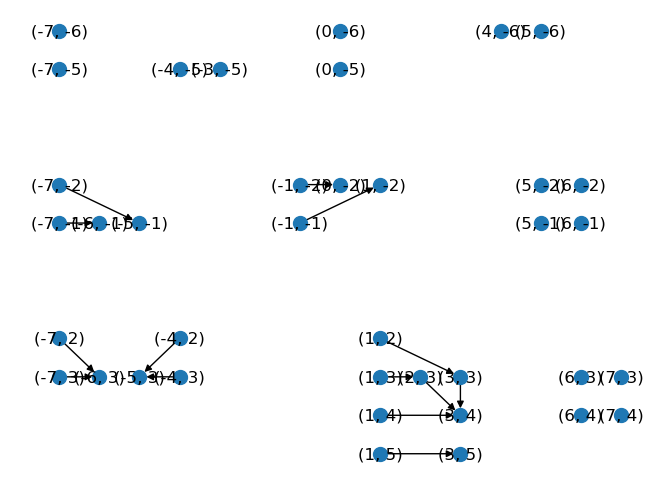

In [30]:
dag = nx.DiGraph()

basic_belts_df['belt_node'] = basic_belts_df.apply(lambda x: L1Belt(x.position, x.direction, dag), axis=1)
print(dag.number_of_nodes())
for node in basic_belts_df.belt_node:
    node.process_upstream_belts()
print(dag.number_of_nodes())
pos = nx.get_node_attributes(dag, 'pos')
nx.draw(dag, pos=pos, node_size=100, with_labels=True)


42
42


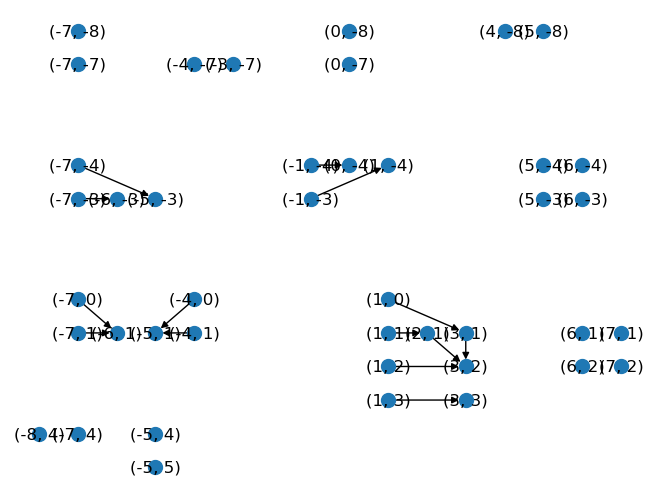

In [34]:
basic_belts_v2 = bp_string_to_json('0eJydldFqgzAUht/lXKcjJ9pavexrjDG0DSOgUWI6JuK7T+taBsegxzs1yZfDn/OZHoryrhtnrIesB3OtbQvZew+t+bJ5OX3zXaMhA+N1BQJsXk1v3uW2bWrnD4UuPQwCjL3pH8hw+BCgrTfe6Jm0vEJAU7fjpNpOe4wLD9HbUUA3P4y8m3H6Oo+rP2L3ae9Vod20i9gOxiA4JmDFAMsg90S4EYOrglxJuDEniFfCuJ7wkQNWQTBN+MQBS0bFyZ6jI1wa8XlPxHK93nRPwoRLA0a5Rw4Cpj2MHOvk9iCQI12w3oUgONI9693QaMiRDhlcjnNh5RbAHOfCP4mFjuA4F4WSoMohx7mgcgsdwXLuCVbrBSuWcyoEpkenHvfp4+7N/l3VAr61a+c1Z4yTVCWxStMoRQFlPm47zr68Zg/DLz26law=')
basic_belts_entities = basic_belts_v2.get('blueprint').get('entities')
basic_belts_df = pd.DataFrame.from_dict(basic_belts_entities)
basic_belts_df = basic_belts_df[basic_belts_df.name == 'transport-belt']
basic_belts_df.drop('entity_number', axis=1, inplace=True, errors='ignore')
basic_belts_df['position'] = basic_belts_df.position.map(lambda d: (d['x'], d['y']))

dag = nx.DiGraph()

basic_belts_df['belt_node'] = basic_belts_df.apply(lambda x: L1Belt(x.position, x.direction, dag), axis=1)
print(dag.number_of_nodes())
for node in basic_belts_df.belt_node:
    node.process_upstream_belts()
print(dag.number_of_nodes())
pos = nx.get_node_attributes(dag, 'pos')
nx.draw(dag, pos=pos, node_size=100, with_labels=True)